### Imports and some functions

prior to executing this notebook please verify that the following packages are in your conda environment

```conda install seaborn scikit-learn py-xgboost statsmodels```

In [2]:
%load_ext autoreload
%autoreload 2

import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

import xgboost as xgb

logging.basicConfig(level=logging.INFO)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def duplicates(X, round=None) -> list:
    """Drop duplicate columns in dataframe

    :param X: input dataframe
    :type X: pandas.core.frame.DataFrame
    :param round: decimal point used for rounding. If set the dataframe is scaled with MinMaxScaler \
    and rounded to the given precision, afterward duplicates are removed. This allows to drop duplicates avoiding \
    floating point precision issues
    :type round: int
    :return: list of columns that are duplicates
    """

    X_ = X.copy()
    if round is not None:
        scaler = MinMaxScaler()
        X_ = pd.DataFrame(scaler.fit_transform(X_),
                          columns=X_.columns,
                          index=X_.index)
        X_ = X_.round(round)
    return X_.columns[X_.T.duplicated()].tolist()


def correlated(X, threshold=0.95) -> list:
    """Decorrelate dataframe by finding which columns shall \
    be removed to achieve correlation level below threshold

    :param X: input dataframe
    :type X: pandas.core.frame.DataFrame
    :param threshold: maximum correlation allowed in the frame X
    :type threshold: float
    :return: list of columns to prune in order to achieve desired decorrelation level
    """

    X_ = X.copy()
    N = X_.shape[1]
    corr = X_.corr().abs()

    to_drop = set()
    for i in range(N - 1):
        for j in range(i + 1, N):
            if corr.iloc[i][j] > threshold and i not in to_drop:
                to_drop.add(j)
    return [X_.columns[i] for i in to_drop]

# Data Preparation

In [4]:
df=pd.read_csv("aryl_amination_subset5.csv", index_col='Pd(0)-ligand_file_name')
df=df.drop('entry', axis=1)

In [5]:
df.head()

,aryl_halide_file_name,aryl_halide_SMILES,aryl_halide_stoichiometry,aryl_halide_number_of_atoms,aryl_halide_charge,aryl_halide_multiplicity,aryl_halide_convergence_criteria,aryl_halide_dipole,aryl_halide_molar_mass,aryl_halide_molar_volume,...,Pd(0)-ligand_vib_42_standard_E-M_angle,Pd(0)-ligand_atom1_%VBur,Pd(0)-ligand_atom2_%VBur,Pd(0)-ligand_atom3_%VBur,Pd(0)-ligand_atom4_%VBur,Pd(0)-ligand_c_min_%VBur,Pd(0)-ligand_c_min+1_%VBur,Pd(0)-ligand_c_max_%VBur,Pd(0)-ligand_c_max-1_%VBur,yield
Pd(0)-ligand_file_name,,,,,,,,,,,,,,,,,,,,,
Pd0-X-Phos,3-chloropyridine,Clc1cccnc1,C5H4ClN,11,0,1,met,2.0883,113.5463,987.175,...,84.6033,0.887309,0.843957,0.819377,0.826712,0.545074,0.550493,0.887309,0.534056,7.787908
Pd0-X-Phos,3-chloropyridine,Clc1cccnc1,C5H4ClN,11,0,1,met,2.0883,113.5463,987.175,...,84.6033,0.887309,0.843957,0.819377,0.826712,0.545074,0.550493,0.887309,0.534056,4.169293
Pd0-X-Phos,3-chloropyridine,Clc1cccnc1,C5H4ClN,11,0,1,met,2.0883,113.5463,987.175,...,84.6033,0.887309,0.843957,0.819377,0.826712,0.545074,0.550493,0.887309,0.534056,6.351542
Pd0-X-Phos,3-chloropyridine,Clc1cccnc1,C5H4ClN,11,0,1,met,2.0883,113.5463,987.175,...,84.6033,0.887309,0.843957,0.819377,0.826712,0.545074,0.550493,0.887309,0.534056,3.963450
Pd0-X-Phos,3-chloropyridine,Clc1cccnc1,C5H4ClN,11,0,1,met,2.0883,113.5463,987.175,...,84.6033,0.887309,0.843957,0.819377,0.826712,0.545074,0.550493,0.887309,0.534056,2.014672


Exclude columns that are not numeric

In [6]:
df=df.select_dtypes(exclude='object')

Scale all data between 0,1

In [7]:
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

Select X and y for regression

In [8]:
X, y = df.loc[:, df.columns != 'yield'], df['yield']
print (f"Number of features: {X.shape[1]}, number of samples: {X.shape[0]}")

Number of features: 1644, number of samples: 791


### Preprocessing

Drop columns with no variance

In [9]:
zero_std = X.std()[X.std() == 0].index
display(f"Zero std columns: {len(zero_std)}")
X = X[X.columns.difference(zero_std)]

'Zero std columns: 493'

Drop columns that are duplicates of some other columns

In [10]:
dupes = duplicates(X, round=3)
display(f"Duplicate columns: {len(dupes)}")
X = X[X.columns.difference(dupes)]

'Duplicate columns: 191'

Drop columns very highly correlated to some other columns

In [11]:
high_corr = correlated(X, threshold=0.99)
display(f"Correlated features: {len(high_corr)}")
X = X[X.columns.difference(high_corr)]

'Correlated features: 675'

In [12]:
print (f"Number of features: {X.shape[1]}, number of samples: {X.shape[0]}")

Number of features: 285, number of samples: 791


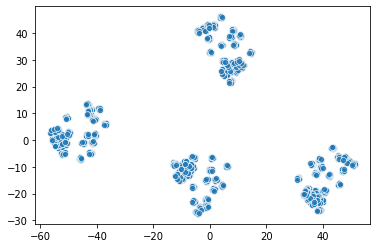

In [13]:
# Chemistry world loves t-SNE plots, so let's make it
tX = TSNE().fit_transform(X)
sns.scatterplot(x=tX[:,0], y=tX[:, 1], alpha=0.8)

# Dimensionality reduction

It is commonly seen in Chem data analysis to reduce dimensions, just remember there are pro's and con's of doing that, depending on the task at hand.

### PCA (option 1)
Principal component analysis. Diagonalize covariance of X and order the eigenvectors by their variance.

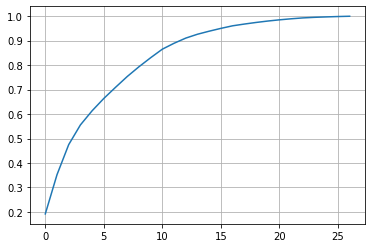

In [14]:
p = PCA()
X_pca = p.fit_transform(X)
explained_var = pd.Series(p.explained_variance_ratio_.cumsum())
explained_var[explained_var < 1].plot(grid=True)

In [15]:
n_pc = 20
X_pca = X_pca[:, :n_pc]

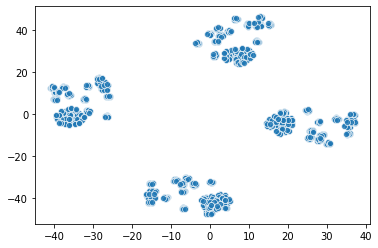

In [16]:
# let's redo the t-SNE plot and see whether things changed
tX_pca = TSNE().fit_transform(X_pca)
sns.scatterplot(x=tX_pca[:,0], y=tX_pca[:, 1], alpha=0.8)

### Decorrelation (option 2)
Remove features sequentially by iteratively reducing the correlation thershold, until a desired amount of features remains.

In [17]:
n_features = 30

X_decorr = X.copy()
th = 0.99
while X_decorr.shape[1] > n_features:
    print (f" correlation threshold: {th}, number of features: {X_decorr.shape[1]}")
    high_corr = correlated(X_decorr, threshold=th)
    X_decorr = X_decorr[X_decorr.columns.difference(high_corr)]
    th = round(th - 0.01, 2)

 correlation threshold: 0.99, number of features: 285
 correlation threshold: 0.98, number of features: 285
 correlation threshold: 0.97, number of features: 219
 correlation threshold: 0.96, number of features: 196
 correlation threshold: 0.95, number of features: 183
 correlation threshold: 0.94, number of features: 172
 correlation threshold: 0.93, number of features: 157
 correlation threshold: 0.92, number of features: 150
 correlation threshold: 0.91, number of features: 144
 correlation threshold: 0.9, number of features: 140
 correlation threshold: 0.89, number of features: 127
 correlation threshold: 0.88, number of features: 123
 correlation threshold: 0.87, number of features: 121
 correlation threshold: 0.86, number of features: 117
 correlation threshold: 0.85, number of features: 112
 correlation threshold: 0.84, number of features: 109
 correlation threshold: 0.83, number of features: 104
 correlation threshold: 0.82, number of features: 98
 correlation threshold: 0.81, 

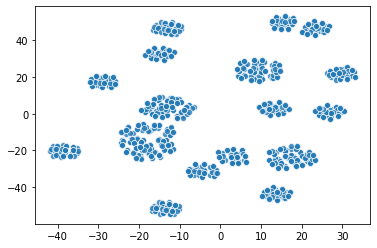

In [18]:
# redo t-SNE
tX_decorr = TSNE().fit_transform(X_decorr)
sns.scatterplot(x=tX_decorr[:,0], y=tX_decorr[:, 1], alpha=0.8, )

## Autoencoder (option 3) - for later

The sample in this tutorial is very small, the neural nets are most data-hungry structures that exist, and therefore autoencoder will likely not work very well.

A neural net that passes the input ```X``` data through a bottleneck (reduced dim representation) and aims to reproduce itself

<img src=https://miro.medium.com/max/1894/1*Uz3sGf9XyLyD5AfcUE9n3w.png style="width:400px" align="left">

# Modelling
with single "l" in the US, double "ll" everywhere else

Select ```X_reg``` features to use, either the entire ```X``` matrix, or one of the ```X_pca```, ```X_decorr```

In [19]:
X_reg = X.copy()

X_reg = pd.DataFrame(X_reg, index=df.index)

### Create training and testing datasets.

This is straightforward if all your data samples are independent. But in this dataset it can't be further from true, the same ingredients are used over and over, so individual data points are not independent. We will split the dataset by ligands.

In [20]:
ligands = df.index.unique()
ligands.tolist()

['Pd0-X-Phos', 'Pd0-t-Bu-X-Phos', 'Pd0-t-Bu-BrettPhos', 'Pd0-Ad-BrettPhos']

In [21]:
train_index = ligands[:3]
test_index = ligands[3:]

In [22]:
X_train = X_reg.loc[train_index].values
X_test = X_reg.loc[test_index].values
y_train = y.loc[train_index].values
y_test = y.loc[test_index].values

In [23]:
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import mean_absolute_error, r2_score, explained_variance_score

import statsmodels.api as sm

### Linear Regression

In [25]:
lr = LinearRegression(fit_intercept=True).fit(X_train, y_train)
y_pred = lr.predict(X_test)

 R2: -1.030066142671897e+26, MAE: 3210741026090.4683


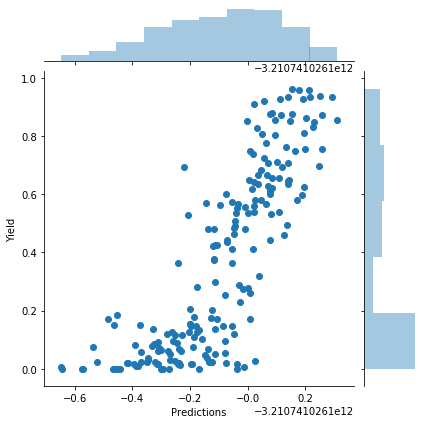

In [26]:
print (f" R2: {round(r2_score(y_test, y_pred), 4)}, MAE: {round(mean_absolute_error(y_test, y_pred), 4)}")

data=pd.concat([pd.Series(y_pred), pd.Series(y_test)], axis=1)
data.columns=['Predictions', 'Yield']

g = sns.jointplot(x='Predictions', y='Yield', data=data)  

Something went badly wrong, Linear Regression works well only in a very specific regime:
- all features in X well uncorrelated
- many more data samples than parameters to estimate
- actualy relationship is linear

### Regularized Linear Regression (Lasso)

Linear regressions are prone to overfitting, one way to address that issue is to impose a penalty on the regression parameter's size. This is called regularization, it helps with
 - high correlations in X features, the penalty will tend to choose a single variable instead
 - data samples per parameter to estimate do not need to be that large
 - actual relationship still needs to be linear!


Adding a penalty term to the optimization adds another objective, the first being to fit the data. One needs to determine the balance between fitting the data well and not having too large parameters. This determination is done using training data.

In [33]:
model = LassoCV(cv=5).fit(X_train, y_train)
y_pred = model.predict(X_test)

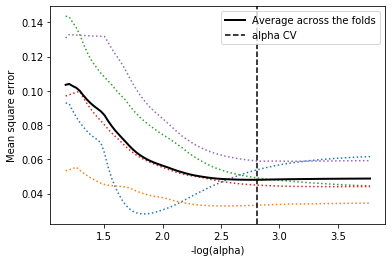

In [35]:
# Display results
EPSILON = 1e-4
m_log_alphas = -np.log10(model.alphas_ + EPSILON)

plt.figure()
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha CV')
plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.axis('tight')

plt.show()

 R2: 0.5936, MAE: 0.1653


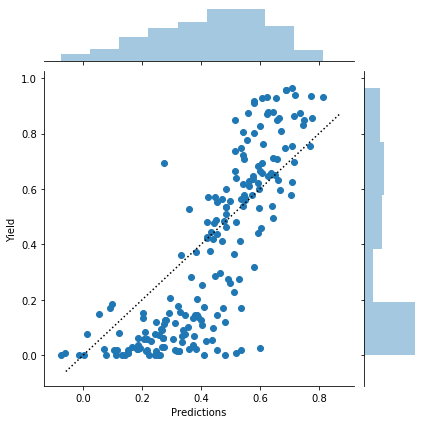

In [36]:
print (f" R2: {round(r2_score(y_test, y_pred), 4)}, MAE: {round(mean_absolute_error(y_test, y_pred), 4)}")

data=pd.concat([pd.Series(y_pred), pd.Series(y_test)], axis=1)
data.columns=['Predictions', 'Yield']

g = sns.jointplot(x='Predictions', y='Yield', data=data)
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, ':k')   

### Random Forest

Random forest is really forgiving! It handles well correlations in your ```X```, it handles any possible non-linearity, including kinks and gaps, and it's not very data-hungry. 

In [38]:
from sklearn.ensemble import RandomForestRegressor

In [39]:
rf = RandomForestRegressor(n_estimators=100)

In [40]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

 R2: 0.844, MAE: 0.0988


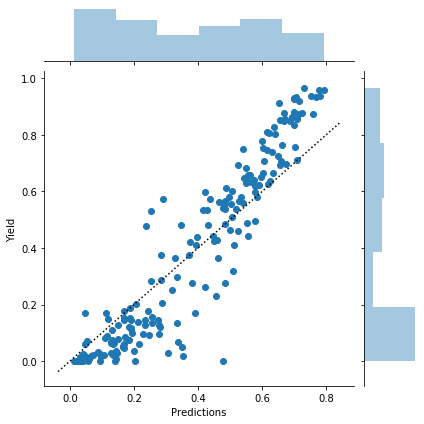

In [41]:
print (f" R2: {round(r2_score(y_test, y_pred), 4)}, MAE: {round(mean_absolute_error(y_test, y_pred), 4)}")

data=pd.concat([pd.Series(y_pred), pd.Series(y_test)], axis=1)
data.columns=['Predictions', 'Yield']

g = sns.jointplot(x='Predictions', y='Yield', data=data)
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, ':k')   

### Boosted decision trees

This is somewhat similar to RandomForest but it's trained a little differently. This methodology has won multiple Machine Learning competitions. It takes some time to tune its parameters, unlike for RandomForest where default parameters often do quite well, but it's very powerful.

In [42]:
import xgboost as xgb

In [43]:
params = {"objective": "reg:squarederror",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 8,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent":1,
          }
num_boost_round = 1000

In [44]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [45]:
watchlist = [(dtrain, 'train'), (dtest, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=100, verbose_eval=False)

In [46]:
y_pred=gbm.predict(dtest)

 R2: 0.8863, MAE: 0.0816


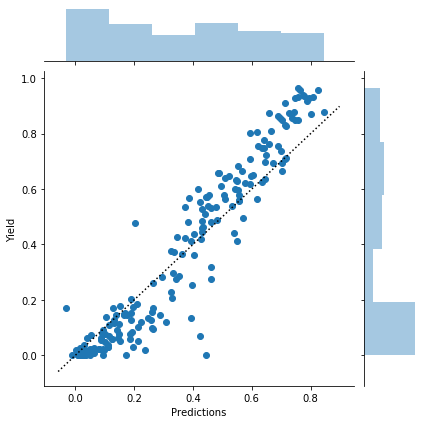

In [47]:
print (f" R2: {round(r2_score(y_test, y_pred), 4)}, MAE: {round(mean_absolute_error(y_test, y_pred), 4)}")

data=pd.concat([pd.Series(y_pred), pd.Series(y_test)], axis=1)
data.columns=['Predictions', 'Yield']

g = sns.jointplot(x='Predictions', y='Yield', data=data)
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, ':k')   